In [23]:
# Add additional library
import sys, os
data_lib = os.path.abspath('../data')
if data_lib not in sys.path:
    sys.path.append(data_lib)

from data_utils import *
from visualisation_utils import *
from scipy import signal

In [8]:
BVP_SAMPLING_RATE = 64

dp_manager = get_data_path_manager()
wesad_wrist_metadata = load_metadata(dp_manager.WESAD_wrist_metadata_path)

In [14]:
DATASET_NAME = 'WESAD'
DEVICE = 'wrist'
SIGNAL_NAME = 'BVP'
USER_ID = 'S10'

In [15]:
raw_signal = load_raw_signal(dp_manager, DATASET_NAME, USER_ID, DEVICE, SIGNAL_NAME)
user_metadata = wesad_wrist_metadata[USER_ID]

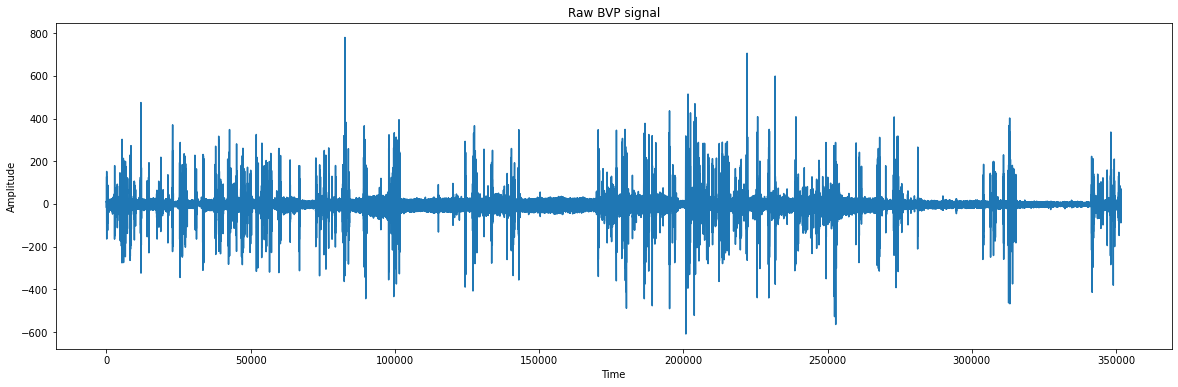

In [16]:
plot_signal(raw_signal, title = 'Raw BVP signal')

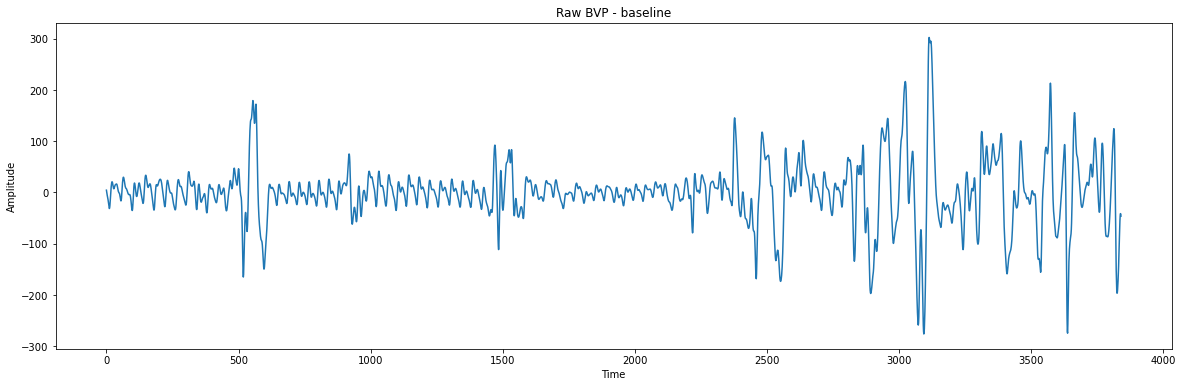

In [22]:
for i, label in enumerate(user_metadata['labels']):
    starting_index = user_metadata['bvp']['starting_indices'][i]
    ending_index = user_metadata['bvp']['ending_indices'][i]
    trim_indices = (starting_index, ending_index)
    trimmed_signal = get_trimmed_signal(raw_signal, trim_indices, lag = 60, sampling_rate = BVP_SAMPLING_RATE)
    title = f'Raw BVP - {label}'
    plot_signal(trimmed_signal[200:200 + BVP_SAMPLING_RATE * 60], title = title)
    break

In [25]:
b, a = signal.butter(4, 0.5, btype='highpass', fs=BVP_SAMPLING_RATE)
output = signal.filtfilt(b, a, trimmed_signal[200:200 + BVP_SAMPLING_RATE * 60])
plot_signal(output, title = f'Butterworth filter BVP - {label}')